# Methadone Clinic Coverage in the Chicago Area 
#### Adapted from the [Opioid Environment Toolkit](https://geodacenter.github.io/opioid-environment-toolkit/index.html)

The Center for Spatial Data Science at UChicago created several tutorials for their
[Opioid Environment Toolkit](https://geodacenter.github.io/opioid-environment-toolkit/index.html) focusing on how methadone clinics serve the chicago area. This code is adapted from their toolkit for use in the HEAL platform.

The Opioid Environment Policy Scan (OEPS) is a database providing access to data at multiple spatial scales to help characterize the multi-dimensional risk environment impacting opioid use in justice populations across the United States. The OEPS and the Opioid Environment Toolkit, from which this script was adapted, were developed for the JCOIN network by Marynia Kolak, Qinyun Lin, Susan Paykin, Moksha Menghaney, and Angela Li at the Center for Spatial Data Science at the University of Chicago as part of the Methodology and Advanced Analytics Resource Center (MAARC). 


Citation:

Marynia Kolak, Qinyun Lin, Susan Paykin, Moksha Menghaney, & Angela Li. (2021, May 11). GeoDaCenter/opioid-policy-scan: Opioid Environment Policy Scan Data Warehouse (Version v0.1-beta). Zenodo. http://doi.org/10.5281/zenodo.4747876

### In this notebook, I use three parts of the this tutorial:

1. buffer analysis (ie what percent of the chicago area is close to a clinic?)
2. using these buffers in the context of other meaningful community data (ie COVID case rates as use case)
3. coverage by a designated regions (ie zip codes).


While much of the code is directly from the Toolkit tutorial, I also expanded to make it usable within the HEAL platform and within a R Kernel Jupyter Notebook environment and to learn a few additional functions to quantify results.

This notebook shows how to use both locally uploaded files in combination with HEAL platform specific files.

Specifically, COVID data has been uploaded locally while geometric and clinic files are taken from the OEPS database on the heal platform.

In [1]:
#suppress warnings (to include warnings,set warn to 0)
options(warn=-1)

In [3]:
library(sf)
library(tidygeocoder)
library(tmap)
library(tidyverse)
library(readxl)
library(units)

In [4]:
#if heal
#see what manifest folder is mounted
manifest_folder_dir <- "/home/jovyan/pd/data/preprod.healdata.org"
manifest_folder_list <- list.files(manifest_folder_dir)
manifest_folder_list

[1] "manifest-2021-07-06T03-47-42.310993" "manifest-2021-07-07T17-26-55.033258"

In [5]:
#if heal
oeps_dir <- paste(
    manifest_folder_dir,
    manifest_folder_list[2],
    "by-filename",
    sep="/"
)

In [6]:
oeps_dir

[1] "/home/jovyan/pd/data/preprod.healdata.org/manifest-2021-07-07T17-26-55.033258/by-filename"

In [7]:
#local data on HEAL platform
local_data_dir = '/home/jovyan/pd/oeps-r-library/data'

In [8]:
#if local folder
#oeps_dir <- 'data_oeps_repo'

In [9]:
add_oeps_dir <- function(filename){paste(oeps_dir,filename,sep='/')}

# Geocoding from addresses

A common goal in opioid environment research is to calculate and compare access metrics to different providers of Medications for Opioid Overuse Disorder (MOUDs). Before we can run any analytics on the resource location data, we need to convert resource addresses to spatial data points, which can be then used to calculate access metrics. 

**Geocoding** is the process of converting addresses (like a street address) into geographic coordinates using a known coordinate reference system. We can then use these coordinates (latitude, longitude) to spatially enable our data. This means we convert to a spatial data frame (sf) within R for spatial analysis within our R session, and then save as a shapefile (a spatial data format) for future use. In this tutorial we demonstrate how to geocode resource location addresses and convert to spatial data points that can be used for future mapping and geospatial analysis. 

In [10]:
#get zip - county crosswalk to filter zip codes for Cook County
#Cook County (county Chicago is in) FIPS code = 17-031
cook_county_zips <- read_excel(add_oeps_dir("ZIP_COUNTY.xlsx")) %>%
    filter(COUNTY==17031)

In [11]:
allClinics <- read.csv(add_oeps_dir('us-wide-moudsCleaned.csv'))
names(allClinics) <-c(
    "name1",
    "name2" ,
    "street1" ,
    "street2" ,
    "city" ,
    "state" ,
    "zip" ,
    "zip4" ,
    "category",
    "countyGEOID" ,
    "countyName" ,
    "source",
    "geom1"  ,
    "geom2",
    "Longitude",
    "Latitude"  
)

In [12]:
methadoneClinics <- allClinics %>%
    filter(countyGEOID==17031 & category=='methadone')

In [13]:
#project to coordinate system 
#longitude and latitude contrary to common lat/long
methadoneSf <- st_as_sf(methadoneClinics, 
                        coords = c("Longitude", "Latitude"),
                        crs = 4326)

In [14]:
#geocode projection in geometry field
head(tibble(methadoneSf),3)

name1,name2,street1,street2,city,state,zip,zip4,category,countyGEOID,countyName,source,geom1,geom2,geometry
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<POINT [°]>
Elite Houses of Sober Living,Elite Treatment Center,395 West Lincoln Highway,NA,Chicago Heights,IL,60411,NA,methadone,17031,Cook,SAMHSA,c(-87.6576384,41.5062933),POINT (-87.65764 41.50629)
Radius Foundation Inc,NA,11952 South Harlem Avenue,Suite 100,Palos Heights,IL,60463,NA,methadone,17031,Cook,SAMHSA,c(-87.7972744,41.6737572),POINT (-87.79727 41.67376)
Symetria Recovery,Palos Heights,11925 South Harlem Avenue,NA,Palos Heights,IL,60463,1138,methadone,17031,Cook,SAMHSA,c(-87.7963882,41.6745493),POINT (-87.79639 41.67455)


Show projection of points on interactive Open Street map:

In [15]:
tmap_mode("view")
## tmap mode set to interactive viewing
#notebook edit: not rendering interactive so need to save rendered hmtl as variable with print fxn
clinic_map <- tm_shape(methadoneSf) + 
    tm_dots() + 
    tm_basemap("OpenStreetMap") +
    tm_view(
        set.bounds=c(-87.94011,41.64454,-87.52414,42.02304),
        alpha = 1
    )
#tmap_save(clinic_map,'clinic_map')

clinic_rendered <- print(clinic_map)
tmap_save(tm=clinic_map,file='clinic_render.html')
#clinic_rendered

tmap mode set to interactive viewing

Interactive map saved to /home/jovyan/pd/clinic_render.html



# Buffer analysis

Once we have spatially referenced resource locations, it's helpful to plot the data in the community of interest for some preliminary analysis. In this tutorial we will plot Methadone Providers in Chicago and community areas to provide some context. We will also generate a simple 1-mile **buffer service area** around each provider to highlight neighborhoods with better, and worse, access to resources. In order to accomplish this task, we will need to standardize our spatial data (clinic points, and community areas) with an appropriate coordinate reference system. Finally, we'll make some maps!

Our objectives are thus to:

* Overlay clinical providers (points) and community areas (polygons)
* Use a spatial transform operation to change coordinate reference systems
* Conduct a simple buffer analysis

In [16]:
shapefile <- read_sf(add_oeps_dir('zctas2018.shp'))

In [17]:
#filter shapefile with only cook county zips
areas <- shapefile %>% filter(ZCTA5CE10 %in% cook_county_zips$ZIP)

In [18]:
#local file
##can get directly from github or uploaded locally
cityBoundary <- st_read(paste0(local_data_dir,"/boundaries_chicago.geojson"))

Reading layer `boundaries_chicago' from data source 
  `/home/jovyan/pd/oeps-r-library/data/boundaries_chicago.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -87.94011 ymin: 41.64454 xmax: -87.52414 ymax: 42.02304
Geodetic CRS:  WGS 84


tmap mode set to plotting



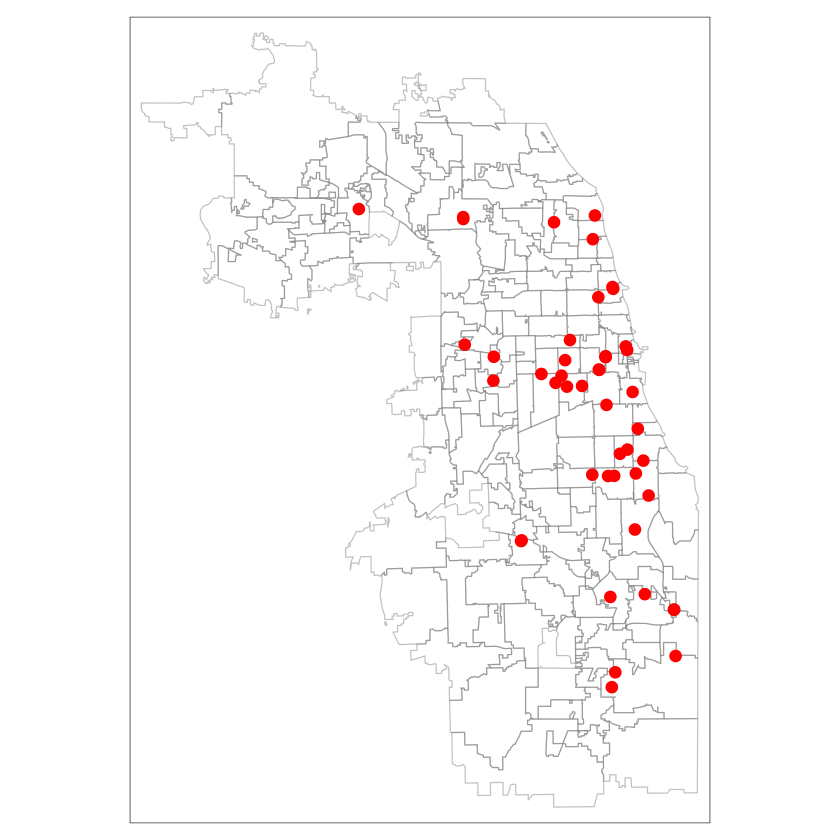

In [19]:
#plot to show geocoding performed as desired
tmap_mode("plot")

## 1st layer (gets plotted first)
tm_shape(areas) + 
tm_borders(alpha = 0.4) + 
## 2nd layer (overlay)
tm_shape(methadoneSf) + 
tm_dots(size = 0.4, col="red") 

In [20]:
#coordinate reference system that preserves distance
CRS.new <- st_crs("EPSG:3435")

In [21]:
#transform datasets to new CRS
metClinics.3435 <- st_transform(methadoneSf, CRS.new)
areas.3435 <- st_transform(areas, CRS.new)

In [22]:
#generate buffer with new CRS but use 5280 ft to equal 1 mile
metClinic_buffers <- st_buffer(metClinics.3435, 5280)

tmap mode set to plotting



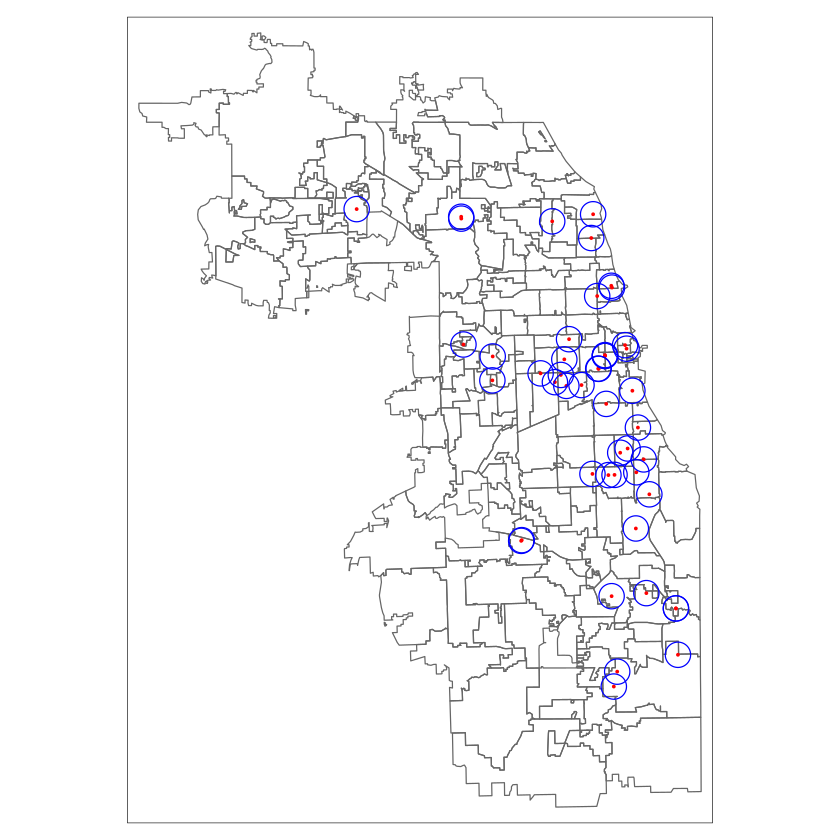

In [23]:
#plot clinic points and 1  mile buffers around clinic
tmap_mode("plot")

tm_shape(areas.3435) + 
tm_borders() +
tm_shape(metClinics.3435) + 
tm_dots(col = "red") +
tm_shape(metClinic_buffers) + 
tm_borders(col = "blue") 

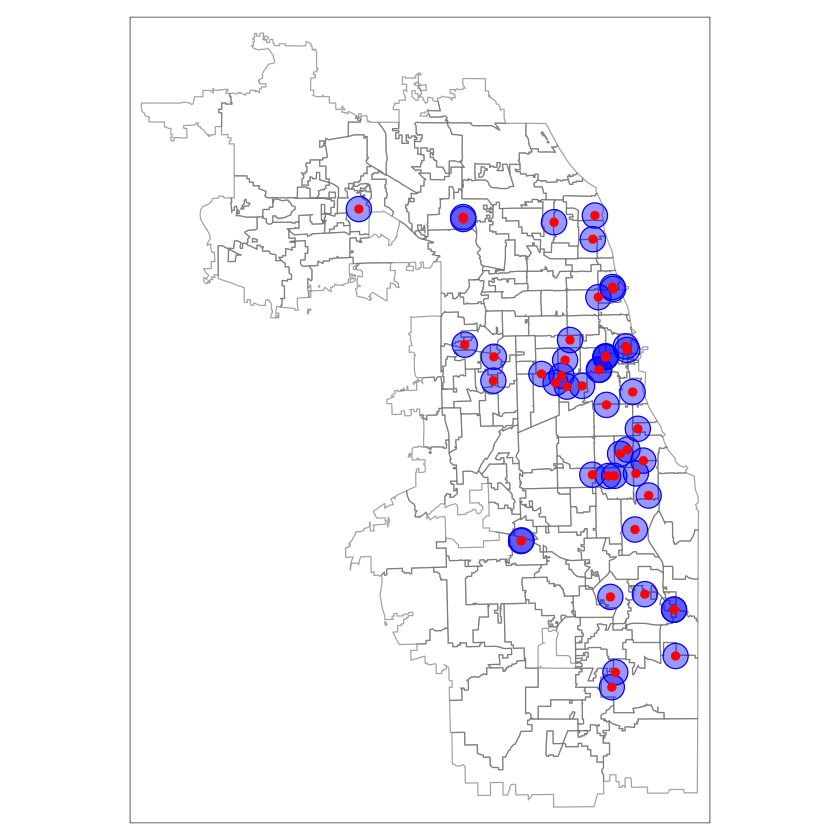

In [24]:
#fill in buffers for easier viz
tm_shape(areas) + 
tm_borders(alpha = 0.6) +
tm_shape(metClinic_buffers) + 
tm_fill(col = "blue", alpha = .4) + 
tm_borders(col = "blue") +
tm_shape(metClinics.3435) + 
tm_dots(col = "red",  size = 0.2) 

In [25]:
#does an area have coverage (ie falls within any one area?)
unionBuffers <- st_union(metClinic_buffers)

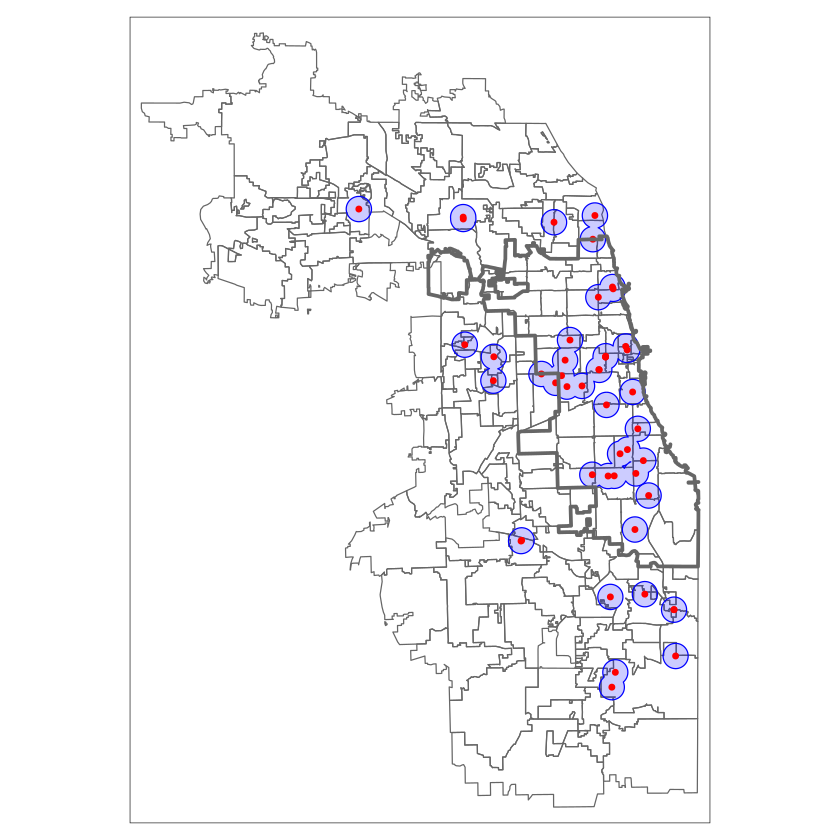

In [26]:
tm_shape(areas) +  
tm_borders()+
tm_shape(unionBuffers) + 
tm_fill(col = "blue", alpha = .2) + 
tm_borders(col = "blue") +
tm_shape(metClinics.3435) + 
tm_dots(col = "red", size = 0.1)+
tm_shape(cityBoundary)+
tm_borders(lwd =3)

In [27]:
metClinic_2mbuffers <- st_buffer(metClinics.3435, 10560)

tmap mode set to plotting



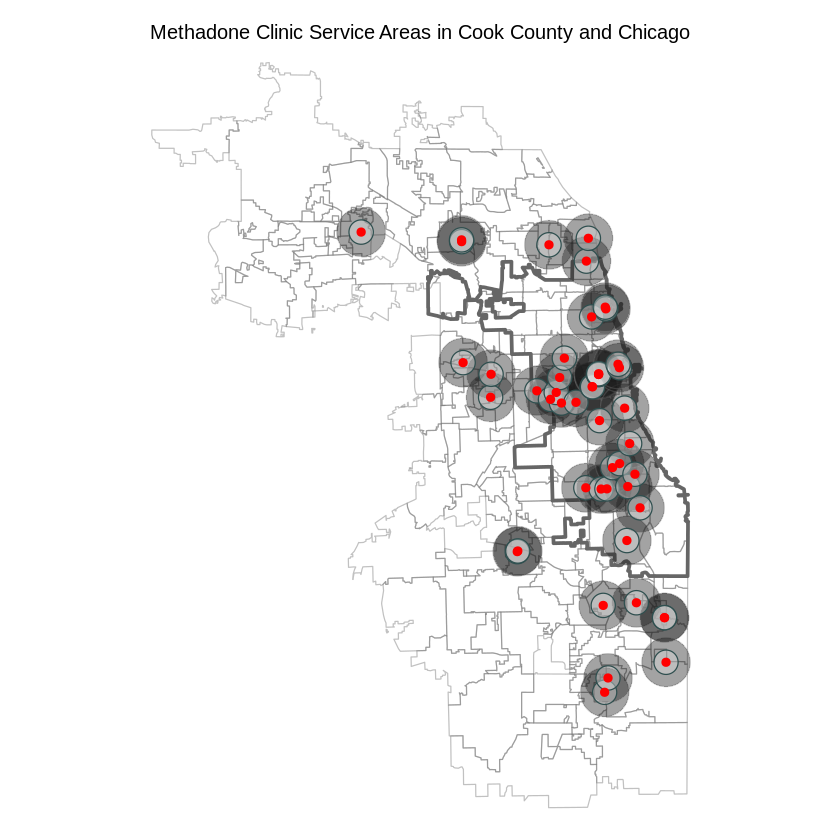

In [28]:
tmap_mode("plot")
tm_shape(areas) + 
tm_borders(alpha = 0.4) +
tm_shape(cityBoundary) + 
tm_borders(lwd = 3) +
tm_shape(metClinic_2mbuffers) + 
tm_fill(col = "gray10", alpha = .4) + 
tm_borders(col = "dimgray", alpha = .4) +
tm_shape(metClinic_buffers) + 
tm_fill(col = "gray90", alpha = .4) + 
tm_borders(col = "darkslategray") +
tm_shape(metClinics.3435) + 
tm_dots(col = "red",  size = 0.2) +   
tm_layout(main.title = "Methadone Clinic Service Areas in Cook County and Chicago",
        main.title.position = "center",
        main.title.size = 1,
        frame = FALSE)

In [29]:
#does an area have coverage (ie falls within any one area?)
union2mBuffers <- st_union(metClinic_2mbuffers)

tmap mode set to plotting



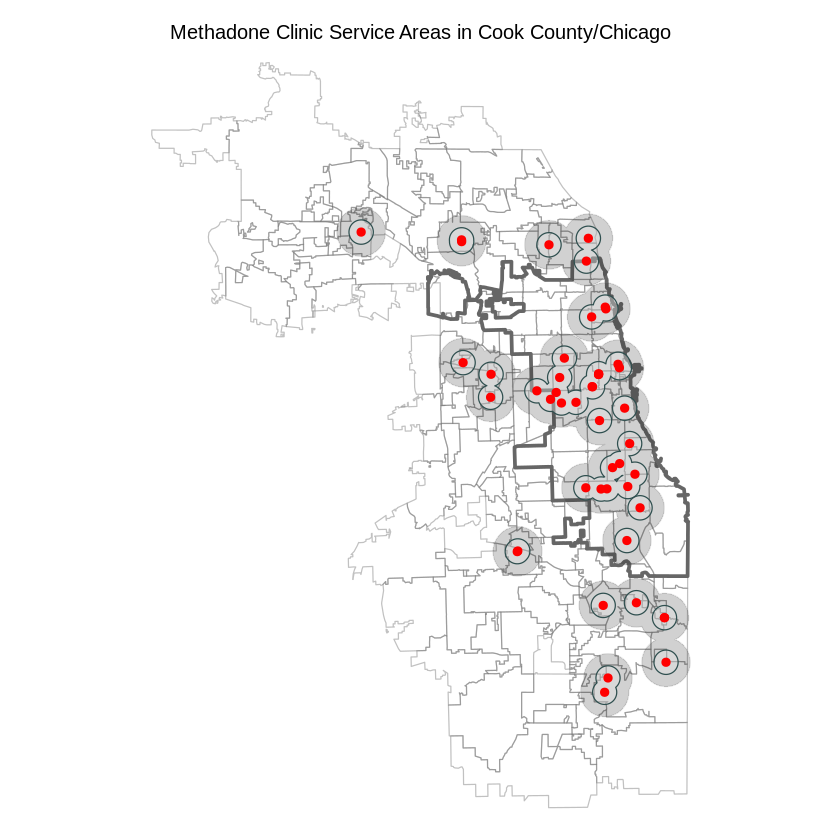

In [30]:
tmap_mode("plot")

tm_shape(areas) + 
tm_borders(alpha = 0.4) +
tm_shape(cityBoundary) + 
tm_borders(lwd = 3) +
tm_shape(union2mBuffers) + 
tm_fill(col = "gray10", alpha = .2) + 
tm_borders(col = "dimgray", alpha = .2) +
tm_shape(unionBuffers) + 
tm_fill(col = "gray90", alpha = .4) + 
tm_borders(col = "darkslategray") +
tm_shape(metClinics.3435) + 
tm_dots(col = "red",  size = 0.2) +   
tm_layout(main.title = "Methadone Clinic Service Areas in Cook County/Chicago",
            main.title.position = "center",
            main.title.size = 1,
            frame = FALSE)

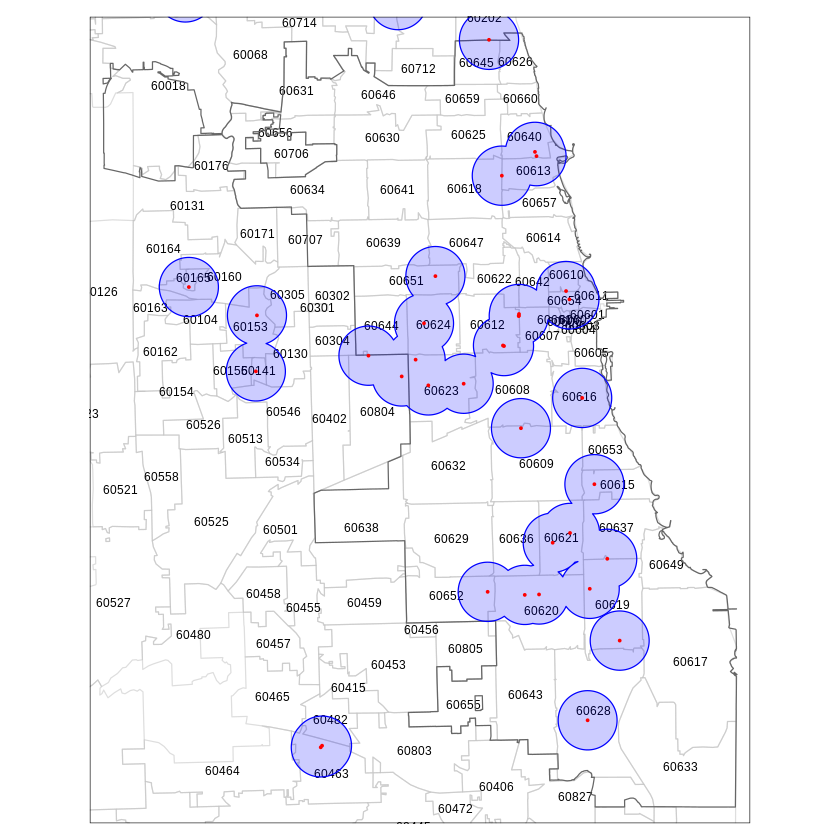

In [31]:
tm_shape(areas,bbox = cityBoundary) +  #zoom in on just chicago
tm_borders(alpha = 0.5, col="gray")+ 
tm_text("GEOID10", size = 0.6) +
tm_shape(cityBoundary) + 
tm_borders() +
tm_shape(unionBuffers) + 
tm_fill(col = "blue", alpha = .2) + 
tm_borders(col = "blue") +
tm_shape(metClinics.3435) + 
tm_dots(col = "red") 

Can do conditional buffers:

1. Eg rural area generally you have larger buffer than urban/suburban.
2. walking distance? generally smaller

### Quantifying resource coverage from buffer analysis

You can then quantify what you are seeing above by creating a simple feature object from the intersection of the city and the buffers with the overall city boundaries using `st_intersection` and `st_area`

In [32]:
#apply the CRS of chicago Centroids to methadone to ensure they are both in same CRS
newCRS <- st_crs(cityBoundary)
unionBuffers_newCRS <- st_transform(unionBuffers, newCRS)
unionBuffers2mi_newCRS <- st_transform(union2mBuffers, newCRS)

In [33]:
#calculate area of chicago with chicago boundary
city_area <- st_area(cityBoundary)
#calculate area of 1 mi buffer and chicago boundary intersection
buffers_and_city_intersection <- st_intersection(unionBuffers_newCRS,cityBoundary)
buffers_2mi_and_city_intersection <- st_intersection(unionBuffers2mi_newCRS,cityBoundary)
#calculate area of 2 mi buffer and chicago boundary intersection
buffer_area <- st_area(buffers_and_city_intersection)

buffer2mi_area <- st_area(buffers_2mi_and_city_intersection)

In [34]:
paste0(
    as.character(
        as.integer(
            (buffer_area/city_area)*100)),
    "% within 1 mile of a resource across Chicago"
)


paste0(
    as.character(
        as.integer(
            (buffer2mi_area/city_area)*100)),
    "% within 2 miles of a resource across Chicago"
)

[1] "25% within 1 mile of a resource across Chicago"

[1] "56% within 2 miles of a resource across Chicago"

### Next Steps

- identify areas and/or points at risk for opiod misuse and run coverage analyses for these areas. 
- for at risk areas, what about 1/2 a mile for buffer?
- other conditionals for buffers (e.g., walkability score for area)

# Linking Community Data

link additional pieces of information with the buffer analysis to target key vulnerable populations. The OEPS tutorial uses the COVID pandemic as a case study. 

1. connect Chicago COVID-19 Case data by ZIP Code, available as a flat file on the city’s data portal, to our environment.

2. overlap the 1-mile buffers representing walkable access to the Methadone providers in the city. COVID impacts travel so conservative, "walkable" threshold used.


3. identify zip codes most impacted by COVID that are outside our acceptable access threshold. 

In [35]:
covid_dir <- paste0(local_data_dir,"/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv")

In [36]:
#read in data for COVID info by zip code
#local file
COVID <- read.csv(covid_dir) %>%
    select(c("ZIP.Code", "Case.Rate...Cumulative")) %>%
    mutate(GEOID10=as.character(ZIP.Code))

In [37]:
#merge COVID with zips
zipsMerged <- merge(areas, COVID, by = "GEOID10")

tmap mode set to plotting



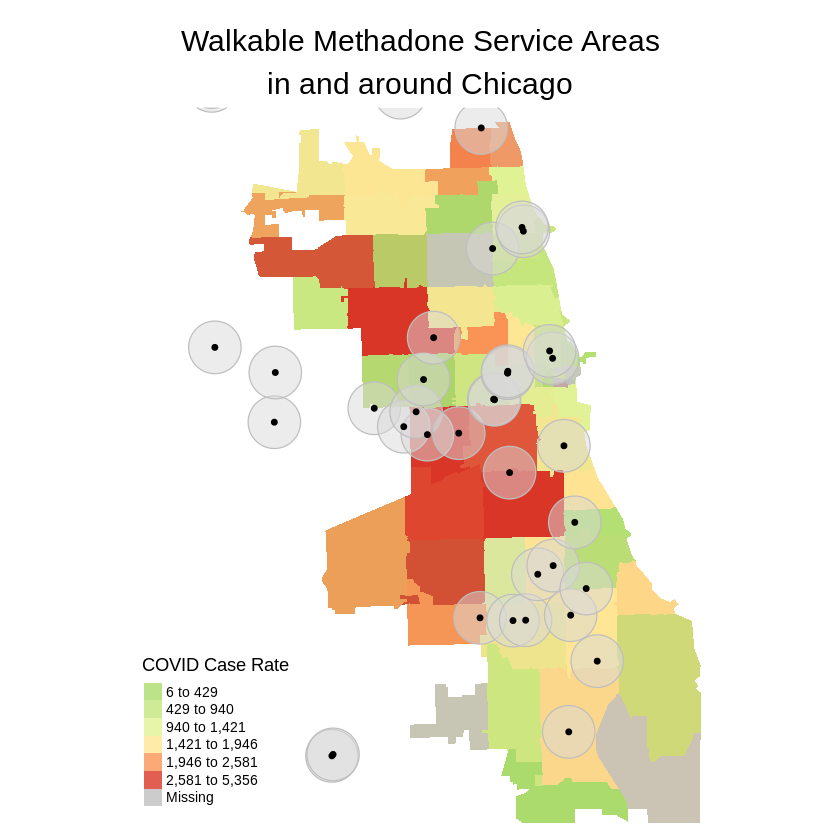

In [38]:
tmap_mode("plot")
tm_shape(zipsMerged,bbox=cityBoundary) +
tm_fill(
    "Case.Rate...Cumulative", style="quantile", n=6, pal="-RdYlGn",
          title = "COVID Case Rate",alpha = 0.8
) + 
tm_borders(lwd = 0) + 
tm_shape(metClinic_buffers,bbox=cityBoundary) + 
tm_borders(col = "gray") +
tm_fill(alpha=0.5) +
tm_shape(methadoneSf,bbox=cityBoundary) + 
tm_dots(col = "black", size = 0.1) +
tm_layout(main.title = "Walkable Methadone Service Areas\nin and around Chicago",
        main.title.position = "center",
        main.title.size = 1.5,
        frame = FALSE)

In [ ]:
tmap_mode("view")
community_interactive <- 
tm_shape(zipsMerged) +
tm_fill(
    "Case.Rate...Cumulative", style="quantile", n=6, pal="-RdYlGn",
          title = "COVID Case Rate",alpha = 0.8
) + 
tm_borders(lwd = 0) + 
tm_shape(metClinic_buffers) + 
tm_borders(col = "gray") +
tm_fill(alpha=0.5) +
tm_shape(methadoneSf) + 
tm_dots(col = "black", size = 0.01) +
tm_layout(main.title = "Walkable Methadone Service Areas",
        main.title.position = "center",
        main.title.size = 1,
        frame = FALSE)

community_interactive_rendered <- print(community_interactive)

tmap_save(tm=community_interactive,file='covid_render.html')

tmap mode set to interactive viewing



### Significance
Of course, this visualization needs a more complete picture of opioid outcomes by zip. But, the red zip codes far from walking distance may be at risk for increased opioid overdoses without intervention (ie from pop up shops).


### Next steps additional visualizations:
- rate of opioid overdose deaths
- opioid related 911 calls

### Insights from linking data with buffers

- This visualization illustrates that many of the high risk areas do not have walkable 
access to a clinic for the majority of that area.

- Obviously, other pieces of community info need to be linked (such as baseline use of opioids for these areas to determine risk) -- see intro for recommendations
                                                             
- Perhaps an action item could be to set up "pop up shop" methadone clinics.                                                    

# Zip centroid analysis

In [ ]:
#change projection of data to a new CRS
chicagoZips <- st_transform(areas, 3435)

In [ ]:
#calculate centroids for each zip code region
chicagoCentroids <- st_centroid(chicagoZips)

In [ ]:
#show the centroids
plot(st_geometry(chicagoZips))
plot(st_geometry(chicagoCentroids), add = TRUE, col = "red")

In [ ]:
#apply the CRS of chicago Centroids to methadone to ensure they are both in same CRS
newCRS <- st_crs(chicagoCentroids)
methadoneSf <- st_transform(methadoneSf, newCRS)

In [ ]:
#now plot both the methadone clinics and the zip centroids
plot(st_geometry(chicagoZips))
plot(st_geometry(chicagoCentroids), col = "red", add = TRUE)
plot(st_geometry(methadoneSf), col = "blue", add = TRUE)

In [ ]:
#identify the nearest clinic to each zip centroid
nearestClinic_indexes <- st_nearest_feature(chicagoCentroids, methadoneSf)
nearestClinic <- methadoneSf[nearestClinic_indexes,]

In [ ]:
#calculate distance to nearest clinic
minDist <- st_distance(chicagoCentroids, nearestClinic, by_element = TRUE)

In [ ]:
#set units to miles
minDist_mi <- set_units(minDist, "mi")

In [ ]:
#join zip codes with the minimum distance data
minDistSf <- cbind(chicagoZips, minDist_mi)

In [ ]:
#visualize minimum distance to each centroid
tmap_mode("plot")
tm_shape(minDistSf) +
tm_polygons("minDist_mi", style = 'quantile', n=5,
          title = "Minimum Distance (mi)") +
tm_shape(methadoneSf) +
tm_dots(size = 0.2) +
tm_layout(main.title = "Minimum Distance from Zip Centroid\n to Methadone Clinic",
        main.title.position = "center",
        frame = FALSE,
        main.title.size = 1)

### Next steps
- clinic coverage vs. OUD : where are high opportunity areas to set up new clinics?
- more continuous view would be more accurately as zip code boundaries and centroids are arbitrary depending on use cases
    - eg., heatmap
    
To do for future  mapping other data
- city wards
- census tracts
- [population density estimates](!https://www.illinois-demographics.com/zip_codes_by_population)


